# Восстановление золота из руды

Компания «Цифры» разрабатывает решения для эффективной работы промышленных предприятий. Подготовим прототип модели машинного обучения, которая будет предсказать коэффициент восстановления золота из золотосодержащей руды. Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Ход работы:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

In [1]:
! pip install panel
! pip install optuna

In [2]:
import pandas as pd
import numpy as np
import datetime
from plotly.subplots import make_subplots
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.multioutput import RegressorChain
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.gofplots import qqplot_2samples
from sklearn.dummy import DummyRegressor
import matplotlib.pyplot as plt
import optuna
import warnings
import plotly.express as px
import plotly.figure_factory as ff
import panel as pn

In [3]:
pd.set_option('display.max_rows', 500) 
pd.set_option('display.max_columns', 500)
optuna.logging.set_verbosity(optuna.logging.WARNING)
pn.extension('plotly')
warnings.simplefilter('ignore',FutureWarning)

In [4]:
def fill (data):
    to_fill = data.isna()
    data = data.fillna(0)
    for i in data.index:
        data.loc[i].fillna(0)
        if(i == 0) and (data.loc[i+1].isna().sum() == 0):
            data.loc[i] += data.loc[i+1] * to_fill.loc[i]
        if(i == len(data)-1) and (data.iloc[-2].isna().sum() == 0):
            data.loc[i] += data.iloc[-2] * to_fill.loc[i]
        if(i != 0) and (i != len(data)-1):
            data.loc[i] += ((data.loc[i+1] + data.loc[i-1])/2)* to_fill.loc[i]
    return data

## Подготовка данных

In [5]:
data_train = pd.read_csv('datasets/gold_recovery_train_new.csv')
data_test = pd.read_csv('datasets/gold_recovery_test_new.csv')
data_full = pd.read_csv('datasets/gold_recovery_full_new.csv')

In [6]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


Обучающая выборка имеет много признаков, многие признаки имеют пропуски, однако их не очень много

In [7]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

Тестовая выборка содержит меньше признаков, чем обучающая, так как некоторые параметры замеряются значительно позже. Посмотрим на различие в признаках

In [8]:
columns_missed_in_test = set(data_train.columns).symmetric_difference(set(data_test.columns))
columns_missed_in_test

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

Достаточно логично, что именно таких признаков нет в тестовой выборке, но они есть в обучающей, так как мы пытаемся имитировать процесс очистки руды и соответственно мы знаем только параметры очистки, но не ее результат, его нам как раз и надо предсказать.

In [9]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


Этот датасет - объединение обучающей и тестовой выборки со всеми признаками.

In [10]:
data_train.columns

Index(['date', 'final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_clean

Проверим эффективность обогащения по формуле для тренировочного датасета и посчитаем получившуюся ошибку

In [11]:
f = data_train['rougher.input.feed_au']
c = data_train['rougher.output.concentrate_au']
t = data_train['rougher.output.tail_au']
recovery = 100*c*(f-t)/(f*(c-t))
print('Процент несовпавших значений = {:.4%}'.format(np.mean(recovery == data_train['rougher.output.recovery'])))
print('MAE =', mean_absolute_error(recovery, data_train['rougher.output.recovery']))

Процент несовпавших значений = 38.4762%
MAE = 1.1498046842860452e-14


Ошибка очень маленькая, да и полностью несовпавших значений меньше 40%, скорее всего это можно списать на погрешность в вычислениях, возможно данные о доли золота в датасете округлены, или же в датасете были использована другая формула, если например этот коэффициент считали через количество полученного концентрата, другая формула - другая погрешность в вычислениях.

Для удобства дальнейшей работы, приведем столбец `date` к типу datetime

In [12]:
data_train['date'] = data_train['date'].apply(datetime.datetime.fromisoformat)
data_test['date'] = data_test['date'].apply(datetime.datetime.fromisoformat)
data_full['date'] = data_full['date'].apply(datetime.datetime.fromisoformat)

Разберемся с пропусками в данных

Проверим, есть ли они в столбцах, которых нет в тестовом датасете

In [13]:
data_full[columns_missed_in_test].isna().sum()

rougher.output.concentrate_sol                          23
final.output.concentrate_sol                           211
rougher.calculation.floatbank11_sulfate_to_au_feed       2
rougher.calculation.floatbank10_sulfate_to_au_feed       2
secondary_cleaner.output.tail_au                         0
primary_cleaner.output.tail_ag                           4
rougher.output.tail_pb                                   0
secondary_cleaner.output.tail_ag                         2
final.output.tail_pb                                   101
final.output.recovery                                    0
rougher.output.tail_sol                                  0
final.output.concentrate_ag                              1
final.output.tail_ag                                     1
rougher.calculation.au_pb_ratio                          0
final.output.tail_sol                                    6
rougher.output.concentrate_au                            0
primary_cleaner.output.tail_pb                          

Да, в некоторых столбцах присутствуют пропуски, однако в целевых столбцах - `final.output.recovery` и `rougher.output.recovery` пропусков нет, также нет пропусков в столбцах, касающихся только золота, так как мы не будем обучать модель по этим признакам, а в целевых признаках пропусков нет, то можно эти пропуски пропустить

In [14]:
data_full[set(data_full.columns).symmetric_difference(columns_missed_in_test)].isna().sum()

rougher.input.floatbank11_sulfate              44
primary_cleaner.state.floatbank8_c_level        1
secondary_cleaner.state.floatbank3_b_air        1
rougher.input.feed_size                       145
secondary_cleaner.state.floatbank4_b_level      1
rougher.input.floatbank11_xanthate            453
rougher.state.floatbank10_d_level               0
rougher.input.feed_sol                         99
primary_cleaner.state.floatbank8_d_air          3
secondary_cleaner.state.floatbank2_b_air       23
primary_cleaner.state.floatbank8_b_air          4
secondary_cleaner.state.floatbank5_a_level      1
primary_cleaner.state.floatbank8_c_air          2
rougher.input.feed_ag                           0
primary_cleaner.input.feed_size                 0
secondary_cleaner.state.floatbank5_b_air        1
rougher.state.floatbank10_c_air                 1
secondary_cleaner.state.floatbank3_b_level      1
rougher.state.floatbank10_b_level               1
rougher.state.floatbank10_f_air                 0


Очень много столбцов, где всего 1-2 пропуска, предположительно,пропуски в этих столбцах были у одного и того же объекта датасета, проверим это

In [15]:
temp = data_full[set(data_full.columns).symmetric_difference(columns_missed_in_test)].isna().sum(axis = 1)
rating_missing_count = temp[temp!=0].sort_values(ascending=False)
rating_missing_count

114      41
11937     8
11935     8
11934     8
11938     7
         ..
9596      1
9595      1
9594      1
9593      1
19282     1
Length: 1531, dtype: int64

Действительно, строка 114 имеет 41 пропуск, хотя всего признаков 53, конечно, удобнее просто удалить эту строку. Посчитаем теперь количество строк, у которых более 3 пропусков

In [16]:
index_with_numerous_skips = np.sort(rating_missing_count[rating_missing_count > 3].index.to_list())
print(len(index_with_numerous_skips))

23


Таких строк совсем немного, поэтому удалим их, так как в них много пропусков, и их заполнение внесет много неточностей в данные об этих объектах

In [17]:
index_in_train = data_train[data_train['date'].isin(data_full.loc[index_with_numerous_skips,:]['date'])].index
data_train = data_train.drop(index_in_train)

index_in_test = data_test[data_test['date'].isin(data_full.loc[index_with_numerous_skips,:]['date'])].index
data_test = data_test.drop(index_in_test)

data_full = data_full.drop(index_with_numerous_skips)

Посмотрим сколько осталось пропусков

In [18]:
data_full[set(data_full.columns).symmetric_difference(columns_missed_in_test)].isna().sum()

rougher.input.floatbank11_sulfate              37
primary_cleaner.state.floatbank8_c_level        0
secondary_cleaner.state.floatbank3_b_air        0
rougher.input.feed_size                       143
secondary_cleaner.state.floatbank4_b_level      0
rougher.input.floatbank11_xanthate            433
rougher.state.floatbank10_d_level               0
rougher.input.feed_sol                         83
primary_cleaner.state.floatbank8_d_air          2
secondary_cleaner.state.floatbank2_b_air       12
primary_cleaner.state.floatbank8_b_air          2
secondary_cleaner.state.floatbank5_a_level      0
primary_cleaner.state.floatbank8_c_air          1
rougher.input.feed_ag                           0
primary_cleaner.input.feed_size                 0
secondary_cleaner.state.floatbank5_b_air        0
rougher.state.floatbank10_c_air                 0
secondary_cleaner.state.floatbank3_b_level      0
rougher.state.floatbank10_b_level               0
rougher.state.floatbank10_f_air                 0


Так как мы знаем, что соседние по времени параметры часто похожи, то оставшиеся признаки будем заполнять с помощью соседей, заполним средним арифметическим двух ближайших записей, отдельно в тестовом, отдельно в тренировочном датафрейме

In [19]:
data_train.shape

(14130, 87)

In [20]:
columns_to_fill = (set(data_full.columns) & set(data_test.columns)) ^ ({'date'})
data_train = data_train.sort_values(by = 'date').reset_index(drop = True)
temp = data_train.isna().sum(axis = 1)
indexes_to_fill_train = temp[temp != 0].index
data_train.loc[:,columns_to_fill] = fill(data_train.loc[:,columns_to_fill])

data_test = data_test.sort_values(by = 'date').reset_index(drop = True)
temp = data_test.isna().sum(axis = 1)
indexes_to_fill_test = temp[temp != 0].index
data_test.loc[:,columns_to_fill] = fill(data_test.loc[:,columns_to_fill])

In [21]:
common_date = pd.concat([data_train[list(columns_to_fill) + ['date']].set_index('date'),data_test.set_index('date')])
data_full = data_full.set_index('date')
data_full[list(columns_to_fill)] = common_date

In [22]:
data_full.isna().sum().sum()

2668

Проверим обучающую и тестовую выборки на наличие дубликатов

In [23]:
print('Количество дубликатов = ',sum(data_full.duplicated()))

Количество дубликатов =  0


## Анализ данных

Посмотрим, как меняется концентрация металлов на разных этапах восстановления

In [24]:
metals = ['ag','au','pb']
figures = []
for i in range(len(metals)):
    fig = make_subplots(rows = 1, cols = 2, column_titles=[f'Изменение средней концентрации {metals[i]} на каждом из этапов',
                                                            f'Диаграмма размаха концентрации {metals[i]} на каждом из этапов'])
    fig.update_layout(autosize=False,width=1400,height=450)
    data = data_full[[f'rougher.input.feed_{metals[i]}',f'rougher.output.concentrate_{metals[i]}',f'primary_cleaner.output.concentrate_{metals[i]}',f'final.output.concentrate_{metals[i]}']]
    data.columns = ['before','rougher','primary_cleaner','final']
    fig.add_trace(px.funnel(data.mean())['data'][0], 1,1)
    fig.add_trace(px.box(data)['data'][0], 1,2)
    fig.update_layout(showlegend = False)
    figures.append(fig)
tabs = pn.Tabs(*zip(metals,figures))
tabs

BokehModel(combine_events=True, render_bundle={'docs_json': {'0a6e1c7d-70e1-4352-9305-bb2e69b8a915': {'defs': …

In [25]:
figures = []
for i in range(len(metals)):
    fig = make_subplots(rows = 1, cols = 2, column_titles=[f'Изменение средней концентрации {metals[i]} на каждом из этапов в хвостах',
                                                            f'Диаграмма размаха концентрации {metals[i]} на каждом из этапов в хвостах'])
    fig.update_layout(autosize=False,width=1400,height=450)
    data = data_full[[f'rougher.output.tail_{metals[i]}',f'primary_cleaner.output.tail_{metals[i]}',f'final.output.tail_{metals[i]}']]
    data.columns = ['rougher','primary_cleaner','final']
    fig.add_trace(px.funnel(data.mean())['data'][0], 1,1)
    fig.add_trace(px.box(data)['data'][0], 1,2)
    fig.update_layout(showlegend = False)
    figures.append(fig)
tabs = pn.Tabs(*zip(metals,figures))
tabs

BokehModel(combine_events=True, render_bundle={'docs_json': {'82e7e9bb-da64-4249-a5e8-e964870af300': {'defs': …

Самый главный показатель - концентрация золота, значительно увеличивается в процессе очистки, однако в финальном концентрате в среднем золота меньше половины. Также в финальном концентрате очень много выбросов, то есть достаточно много случаев (четверть), когда итоговая концентрация золота ниже примерно 39 процентов. Во время этапа 1 очистки в хвосте может остаться более 10% золота (в среднем около 4%), однако все-таки надо отметить, что средняя концентрация золота очень быстро растет в процессе очистки.

Концентрация серебра после процесса флотации достаточно сильно увеличилась, скорее всего это связано с тем, что масса хвоста после процесса флотации была достаточно большой, и 5.5% в нем составляло серебро, поэтому такой рост можно объяснить большой массой хвоста. Выбросы в диаграмме размаха для концентрации серебра в финальном концентрате может говорить о том, что в некоторых случаях вторая очистка не сильно влияет на концентрацию серебра. Хвосты после первой очистки в среднем на 16% процентов состояли из серебра, в некоторых случаях серебро занимало до 30% хвоста. 

Концентрация свинца изменяется не так уж сильно, и его концентрация в хвостах говорит о том же, после процесса флотации, свинец составлял менее 1% от всего хвоста. Такая низкая концентрация говорит о том, что примесей свинца в золотосодержащей руде достаточно немного. 

Следует также отметить, что в процессе очистки, нижняя граница концентрации металлов не меняется, это может говорить о разноообразности датафрейма, так как в нем есть примеры руды, в которой содержание золота очень маленькое и есть очень много примесей, от которых не удалось избавиться предложенным методом очистки

Исследуем теперь суммарную концентрацию серебра, золота и свинца на разных стадиях очистки

In [26]:
metals = ['ag','au','pb','sol']
fig = make_subplots(rows = 1, cols = 2, column_titles=[f'Изменение средней концентрации металлов на каждом из этапов',
                                                            f'Диаграмма размаха концентрации металлов на каждом из этапов'])
fig.update_layout(autosize=False,width=1400,height=450)
phases = ['rougher.input.feed','rougher.output.concentrate','primary_cleaner.output.concentrate','final.output.concentrate']
data = pd.DataFrame(0, index = data_full.index,columns = phases)
for phase in phases:
    for i in range(len(metals)):
        data[phase] += data_full[phase + f'_{metals[i]}']
data.columns = ['before','rougher','primary_cleaner','final']
fig.add_trace(px.funnel(data.mean())['data'][0], 1,1)
fig.add_trace(px.box(data)['data'][0], 1,2)
fig.update_layout(showlegend = False)

Общая концентрация металлов растет, кроме этапа первичной очистки, на диаграмме размаха мы видим огромные выбросы, которые растут с каждым этапом, что значит, что основная масса очисток в датафрейме подчиняется процессам обогащения, и концентрация на каждом этапе у этой массы не сильно варьируется, однако есть примеры, и их достаточно много, когда процесс обогащения и очистки работал плохо или же совсем не работал, или же это часть аномальный данных. Постепенно все больше и больше квартили стремятся к медиане, то есть у 50% разбежка в концентрации металлов небольшая, медиана финальной концентрации = 69%. 

На каждом из этапов очистки есть много выбросов - значений около 0, скорее всего эти данные являются аномальными, ведь едва ли после 3 этапов очистки концентрация металлов близка к 0,  удалим часть значений до 3-го перцентиля, чтобы модель не обучилась на недостоверных данных и не была протестирована на невозможных синтетических данных

In [27]:
for phase in phases:
    temp_sum_train = pd.Series(0,index = data_train.index)
    temp_sum_test = pd.Series(0,index = range(len(data_test.index)))
    for i in range(len(metals)):
        temp_sum_train += data_train[phase + f'_{metals[i]}']
        temp_sum_test += data_full.loc[data_test.date,:][phase + f'_{metals[i]}'].reset_index(drop = True)
    data_train = data_train[temp_sum_train > temp_sum_train.quantile(0.03)]
    data_test = data_test[(temp_sum_test > temp_sum_test.quantile(0.03)).values]
data_full = data_full.loc[np.concatenate([data_train.date.values,data_test.date.values]),:]

In [28]:
data = pd.DataFrame(0, index = data_full.index,columns = phases)
for phase in phases:
    for i in range(len(metals)):
        data[phase] += data_full[phase + f'_{metals[i]}']
data.columns = ['before','rougher','primary_cleaner','final']
fig = px.box(data)
fig.update_layout(width = 800, height = 400, title = 'Диаграмма размаха концентрации металлов на каждом из этапов')

Теперь данные выглядят более правдоподобно 

Сравним также размеры гранул сырья на обучающей и тестовой выборке, так как если размеры будут достаточно сильно отличаться, это может сказаться на плохой работе модели, она обучится на процессе очистки гранул другого размера и будет давать плохие предсказания на тестовой выборке

In [29]:
fig1 = ff.create_distplot([data_train['rougher.input.feed_size'],data_test['rougher.input.feed_size']],
                        ['train','test'],show_hist=False,show_rug = False)
fig1.update_layout(title = 'Распределение размера гранул перед этапом флотации на тренировочной и тестовой выборке',
                   width = 1400, height = 450)
fig2 = ff.create_distplot([data_train['primary_cleaner.input.feed_size'],data_test['primary_cleaner.input.feed_size']],
                          ['train','test'],show_hist=False,show_rug = False)
fig2.update_layout(title = 'Распределение размера гранул перед этапом первичной очистки на тренировочной и тестовой выборке',
                   width = 1400, height = 450)
tabs = pn.Tabs(('rougher',fig1),('primary_cleaner',fig2))
tabs

BokehModel(combine_events=True, render_bundle={'docs_json': {'16e6ab72-51d4-4110-ba11-ca2d730887fc': {'defs': …

Распределения размера гранул перед этапом флотации у тестовой и тренировочной выборке схожи, однако пик распределения у тестовой выборки немного смещен в сторону меньших значений, оба эти распределения - распределения с толстым хвостом, диапазон значений у тренировочной выборки больше, чем у тестовой. Основная масса гранул перед этапом флотации имеет размер от 30 до 85.

Распределения размера гранул перед этапом первичной очистки у тестовой и тренировочной выборки более схожи, чем перед этапом флотации,однако у тренировочной выборки есть толстый хвост в обе стороны, а у тестовой только в одну, диапазон значений уже гораздо меньше, это связано с тем, что гранулы подвергаются процессу дробления, основная масса гранул перед этапом первичной очистки имеет размер от 5.5 - 9 

Посмотрим на график qq-plot и оценим, насколько схожи распределения

Text(0.5, 1.0, 'Этап первичной очистки')

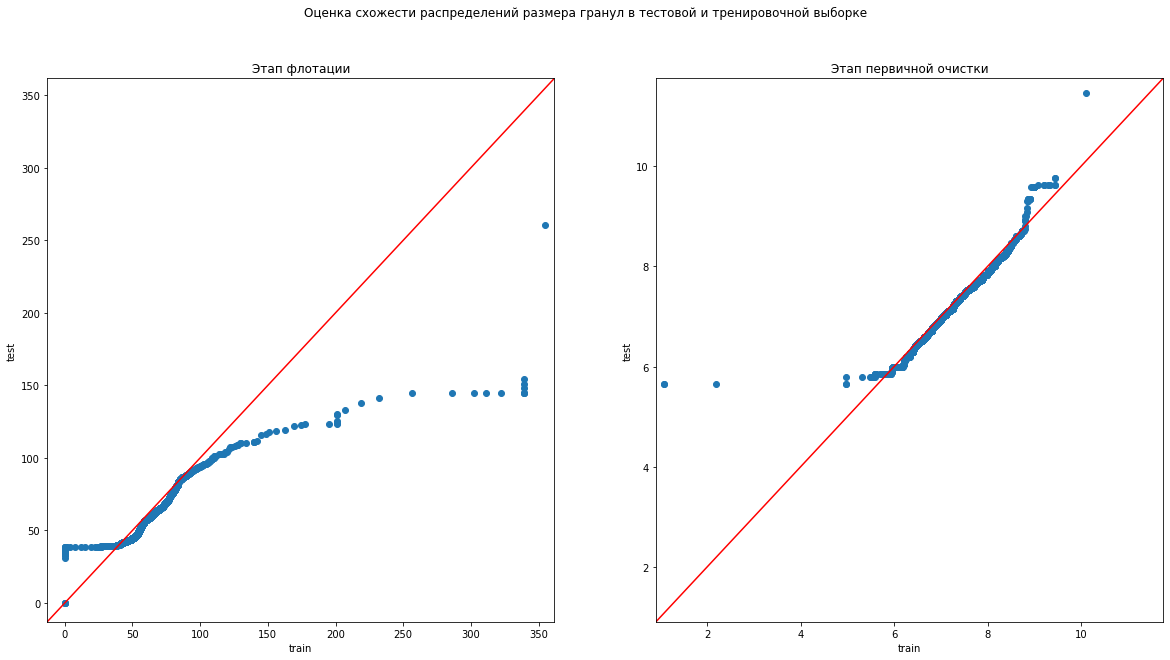

In [30]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20, 10))
plt.suptitle('Оценка схожести распределений размера гранул в тестовой и тренировочной выборке ')
qqplot_2samples(data_train['rougher.input.feed_size'], data_test['rougher.input.feed_size'],line = '45', ax = ax1, xlabel = 'train', ylabel = 'test')
ax1.set_title('Этап флотации')
qqplot_2samples(data_train['primary_cleaner.input.feed_size'], data_test['primary_cleaner.input.feed_size'],line = '45', ax = ax2, xlabel = 'train', ylabel = 'test')
ax2.set_title('Этап первичной очистки')

Линейную зависимость (а значит и схожесть распределений) рушат толстые хвосты, а для этапа флотации еще и смещенный пик распределения, поэтому нельзя сказать, что распределения одинаковые, тренировочные данные и тестовые тут достаточно сильно отличаются, однако все-таки следует отметить, что тренировочные данные достаточно хорошо покрывают тестовые, то есть нет выделяющихся значений в тестовой выборке, которые бы не были встречены в тренировочной, а также интервалы с большой вероятностной мерой в тестовой выборке имеют достаточно высокую частоту и в тренировочной, следовательно для обучения модели такие отличия в распределении размера гранул на тренировочной и тестовой выборке приемлемы. 

## Построим модель

Подберем модель для предсказания значения столбцов `rougher.output.recovery` и `final.output.recovery`

Для начала нужно удалить признаки, которые не нужны для предсказаний, проверим признак date. Посмотрим как коэффициенты обогащения зависит от даты

In [30]:
fig = make_subplots(rows = 2, cols = 1,shared_xaxes = True,subplot_titles=['Изменение коэффициента обогащения после флотации по времени',
                                                                            'Изменение коэффициента финального обогащения по времени'], vertical_spacing=0.1)
fig.update_layout(height = 700)
data_full['is_test'] = data_full.reset_index()['date'].isin(data_test.date.values).values
data = data_full.reset_index()
trace = px.scatter(data, x = 'date', y = 'rougher.output.recovery', color = data['is_test'])
fig.add_trace(trace['data'][0],1,1)
fig.add_trace(trace['data'][1],1,1)
trace = px.scatter(data, x = 'date', y = 'final.output.recovery', color = data['is_test'])
fig.add_trace(trace['data'][0],2,1)
fig.add_trace(trace['data'][1],2,1)

Видим, что зависимости от даты нет, с течением времени тенденция коэффициентов обогащения не меняется, однако сильно выделяются самые ранние наблюдения в тренировочном датасете, примерно до апреля 2016 года, так как наша модель будет, скорее всего, использована для предсказаний будущих процессов очистки руды, а соответственно отличающаяся тенденция до апреля 2016 года будет неактуальна, поэтому удалим из тренировочной выборки данные до апреля 2016

In [ ]:
date_april = datetime.datetime.fromisoformat('2016-04-01')
data_train = data_train.query('date >= @date_april')
data_full = data_full[data_full.index >= date_april]

Удалим `date`, так как период не влияет на коэффициенты эффективности обогащения, и также эта модель будет, скорее всего, использоваться для будущих предсказаний, поэтому информация о дате на тренировочной выборке будет неактуальна, также из обучающей выборки необходимо удалить все те столбцы, которых нет в тестовой, так как наша задача - симулировать процесс обработки золотосодержащей руды и предсказать коэффициент эффективности обогащения после процесса флотации и после финальной очистки. Также так как строки были упорядочены по дате, а как известно, близкие по дате параметры часто схожи, случайно перемешаем датафреймы.

In [ ]:
train_features, train_target = shuffle(data_train[columns_to_fill],data_train[['rougher.output.recovery','final.output.recovery']],random_state = 122333)  
test_features, test_target= shuffle(data_test[columns_to_fill].reset_index(drop = True),
        data_full.loc[data_test.date,:][['rougher.output.recovery','final.output.recovery']].reset_index(drop = True),random_state = 122333)

Будем выбирать модель из 2 моделей для решения задачи регрессии: случайный лес и градиентный бустинг. Проверять качество будем с помощью кросс-валидации, а подбирать наилучшие гиперпараметры с помощью алгоритма TPE. А также, так как поставлена задача предсказать 2 целевые переменные, то сравним 2 метода : цепной, когда сначала предсказывается одна переменная, а потом с помощью этих предсказаний предсказывается другая, и подбор наилучшей модели для кажой из переменных.

Метрикой ошибки в этой задаче для предсказания отдельной целевой переменной будет symmetric mean absolute percentage error, финальная метрика ошибки предсказания 2 целевых переменных - $0.25 \cdot sMAPE(rougher) + 0.75 \cdot sMAPE(final)$

Напишем функцию для расчета ошибки предсказания отдельной целевой переменной

In [ ]:
def smape (target, predictions):
    if(len(predictions.shape) > 1):
        error = smape(target[:,0], predictions[:,0]) * 0.25 + smape(target[:,1],
                                                                    predictions[:,1]) * 0.75
    else:
        error = (200*abs(target - predictions)/(target + predictions)).sum()/len(target)
    return error

In [ ]:
def cross_validation (model,train_features, train_target):
    scores = []
    for train_index, test_index in KFold(n_splits=5).split(train_features):
        temp_train_features, temp_test_features = train_features.iloc[train_index], train_features.iloc[test_index]
        temp_train_target, temp_test_target = train_target.iloc[train_index], train_target.iloc[test_index]
        model.fit(temp_train_features, temp_train_target)
        scores.append(smape(temp_test_target.values, model.predict(temp_test_features))) 
    return np.mean(scores)

In [ ]:
def objective (trial,type):
    regressor_name = trial.suggest_categorical('regressor', ['RandomForestRegressor','GradientBoostingRegressor'])
    n_est = trial.suggest_int('n_estimators',20,150,5)
    depth = trial.suggest_int('max_depth',3,39,3)
    min_samples_split = trial.suggest_int('min_samples_split',2,50,3)
    min_samples_leaf = trial.suggest_int('min_samples_leaf',2,20)
    ccp_alpha = trial.suggest_float('ccp_alpha', 0.0, 0.01, step = 0.00005)
    if regressor_name == 'RandomForestRegressor':
        regressor_model = RandomForestRegressor(random_state = 122333, n_estimators = n_est, max_depth = depth,
                            min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, ccp_alpha = ccp_alpha, n_jobs=-1)
    else:
        learning_rate = trial.suggest_float('learning_rate', 0.0, 0.4,step = 0.00005)
        regressor_model = GradientBoostingRegressor(random_state=122333, n_estimators = n_est, max_depth = depth,
                            min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, ccp_alpha = ccp_alpha)
    if type == 1:
        return cross_validation(regressor_model, train_features, train_target['rougher.output.recovery'])
    elif type == 2:
        return cross_validation(regressor_model, train_features, train_target['final.output.recovery'])
    elif type == 3:
        return cross_validation(RegressorChain(regressor_model), train_features, train_target)

Для начала подберем лучшие гиперпараметры и модель для предсказания целевой переменной `rougher.output.recovery`

In [ ]:
study1 = optuna.create_study(direction="minimize",sampler = optuna.samplers.TPESampler(seed=1223333))
study1.optimize((lambda x: objective(x,1)), n_trials = 80, n_jobs = -1)

Посмотрим на выбранные гиперпараметры и метрику ошибки sMAPE, посчитанную на кросс-валидации

In [ ]:
print('Лучшие гиперпараметры для предсказания `rougher.output.recovery` = ', study1.best_params)
print('sMAPE выбранной модели `rougher.output.recovery` = ', study1.best_value)

Теперь подберем лучшую модель с гиперпараметрами для предсказания целевой переменной `final.output.recovery`.

In [ ]:
study2 = optuna.create_study(direction="minimize",sampler = optuna.samplers.TPESampler(seed=1223333))
study2.optimize((lambda x: objective(x,2)), n_trials = 80, n_jobs = -1)

In [ ]:
print('Лучшие гиперпараметры для предсказания `final.output.recovery` = ', study2.best_params)
print('sMAPE выбранной модели `final.output.recovery` = ', study2.best_value)

Лучшие гиперпараметры для предсказания `final.output.recovery` =  {'regressor': 'GradientBoostingRegressor', 'n_estimators': 80, 'max_depth': 39, 'min_samples_split': 38, 'min_samples_leaf': 16, 'ccp_alpha': 0.0023, 'learning_rate': 0.08525}
sMAPE выбранной модели `final.output.recovery` =  4.826684920434077


Финальная метрика 2 выбранных моделей 

In [ ]:
print('Финальная метрика 2 моделей = ', study1.best_value*0.25 + study2.best_value * 0.75)

Финальная метрика 2 моделей =  4.140286527359174


Теперь подберем лучшую модель с гиперпараметрами для предсказания 2 целевых переменных `rougher.output.recovery` и `final.output.recovery`

In [ ]:
study3 = optuna.create_study(direction="minimize",sampler = optuna.samplers.TPESampler(seed=1223333))
study3.optimize((lambda x: objective(x,3)), n_trials = 80, n_jobs = -1)

In [ ]:
print('Лучшие гиперпараметры для предсказания 2 целевых переменных с использованием цепного метода = ', study3.best_params)
print('sMAPE выбранной модели = ', study3.best_value)

Лучшие гиперпараметры для предсказания 2 целевых переменных с использованием цепного метода =  {'regressor': 'GradientBoostingRegressor', 'n_estimators': 85, 'max_depth': 24, 'min_samples_split': 47, 'min_samples_leaf': 14, 'ccp_alpha': 0.00055, 'learning_rate': 0.0429}
sMAPE выбранной модели =  4.169884478219993


## Проверка модели

Лучше качество показали 2 разные модели для 2 целевых переменных, однако, стоит отметить, что различие в моделях минимальное, также построение 2 разных моделей для разных переменных более гибкое, так как мы можем подобрать наилучшие гиперпараметры для каждой из моделей. Все выбранные модели - модели градиентного бустинга. Проверим выбранную модель на тестовой выборке

In [ ]:
params_1 = study1.best_params
params_2 = study2.best_params
params_2.pop('regressor')
params_1.pop('regressor')
model_rougher = GradientBoostingRegressor(**params_1, random_state = 122333)
model_final = GradientBoostingRegressor(**params_2, random_state = 122333)
model_rougher.fit(train_features, train_target['rougher.output.recovery'])
model_final.fit(train_features, train_target['final.output.recovery'])

GradientBoostingRegressor(ccp_alpha=0.0023, learning_rate=0.08525, max_depth=39,
                          min_samples_leaf=16, min_samples_split=38,
                          n_estimators=80, random_state=122333)

In [ ]:
print('Ошибка на тестовом датасете = ',smape(test_target.values,np.column_stack([model_rougher.predict(test_features), model_final.predict(test_features)])))

Ошибка на тестовом датасете =  6.820774101813091


Сравним выбранные модели с константной.

In [ ]:
model = DummyRegressor(strategy = 'mean')
model.fit(train_features,train_target)
print('Ошибка константной модели = ', smape(test_target.values,model.predict(test_features)))

Ошибка константной модели =  6.916538233755779


Выбранные модели показывают результат лучше, чем константная, однако разница в качестве у них не очень большая, возможно это связано с тем, что большая часть тестового таргета распределена близко к среднему тренировочного таргета, а возможно это связано с тем, что данные признаки не полно описывают процесс и предсказания, основанные на них, недостаточно точны.

## Вывод

Наилучшей моделью для предсказания 2 целевых переменных `rougher.output.recovery` и `final.output.recovery` оказался градиентый бустинг с отдельными гиперпараметрами для каждой переменной, цепной метод с едиными гиперпараметрами оказался чуть хуже, итоговая ошибка на тестовом датасете = 6.84%. 